# Li building PP from OEPP rho with LDA with TF02vW

In [64]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [66]:
from ase.io import read

In [67]:
atoms = read('../../../KS/LDA/rho_ks_Li_oepp.xsf')

In [68]:
ions, rho_ks, _ = io.read_all('../../../KS/LDA/rho_ks_Li_oepp.xsf')
grid = rho_ks.grid


In [69]:
PP_list = {'Li': '/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/PP/Li_OEPP_PZ.UPF'}

In [70]:
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)#, MaxPoints=MaxPoints)
rho_ini =rho_ks.copy()
core = PSEUDO.core_density

In [71]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='LDA', core_density=core)
HARTREE = Functional(type='HARTREE')

In [72]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

In [11]:
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
rho = opt.optimize_rho(guess_rho=rho_ks)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -3.405866861903E-01     -3.405867E-01   1.140254E-03    1       1       4.934871E-01    
1       -3.409954741158E-01     -4.087879E-04   3.486935E-04    1       3       7.029440E-01    
2       -3.410748837796E-01     -7.940966E-05   7.247023E-04    1       3       9.066184E-01    
3       -3.411063000713E-01     -3.141629E-05   9.864445E-04    1       2       1.029622E+00    
4       -3.411367561660E-01     -3.045609E-05   1.337928E-03    1       2       1.148880E+00    
5       -3.411689367104E-01     -3.218054E-05   2.259036E-03    1       3       1.340333E+00    
6       -3.411911038715E-01     -2.216716E-05   1.309448E-03    1       2       1.476428E+00    
7       -3.412138668274E-01     -2.276296E-05   1.215840E-03    1       2       1.608796E+00    
8       -3.412333312317E-01     -1.946440E-05   1.043497E-03    1       2       1.728931E+00    
9       -3.412504012843E-01   

In [12]:
delta = 0.5 * np.abs(rho_ks - rho).integral()

In [13]:
delta

0.029944046029677943

In [14]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)+0.2

In [15]:
from dftpy.mixer.pulay import PulayMixer

In [16]:
from dftpy.optimization import OESCF

In [17]:
pulay=PulayMixer(mp=None)

In [18]:
opt_options = {'econv' : 1e-6}

In [19]:
vW = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vW, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

kedf_emb = Functional(type='KEDF',name='LMGP')#, kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [20]:
rho_lmgp = opt.optimize_rho(guess_rho=rho_ks, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -2.712220976839E-01     -2.712221E-01   6.725065E-06    1       1       6.283784E-02    
1       -2.712222348405E-01     -1.371566E-07   6.762571E-06    1       2       1.921809E-01    
2       -2.712222518347E-01     -1.699421E-08   4.737795E-06    1       3       3.734002E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.002212087390702249
Chemical potential (eV)  : 0.06019396390803418
 OESCF--> iter=1     conv=1.000E-03 de=3.399E-01 energy=-3.399134E-01 time=9.258359E+00
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -2.712288645208E-01     -2.712289E-01   3.265302E-06    1       1       6.477189E-02    
1       -2.712288710236E-01     -6.502751E-09   3.778763E-06    1       3       1.895649E-01    
2       -2.712288924912E-01     -2.146764E-08   9.781636E-06    1       2       2.786491E-01    


In [21]:
delta = 0.5 * np.abs(rho_ks - rho_lmgp).integral()
print(delta)

3.5641472507901376e-05


Text(0.5, 1.0, 'OF LMGP')

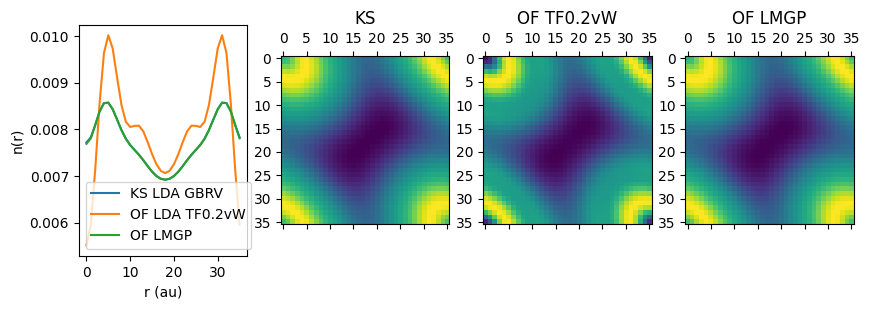

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_ks[0,0,:].ravel()))
cut = 0
axs[0].plot(rho_ks[:,cut,cut].ravel(), label='KS LDA GBRV')
axs[0].plot(rho[:,cut,cut].ravel(), label='OF LDA TF0.2vW')
axs[0].plot((rho_lmgp[:,cut,cut]).ravel(), label='OF LMGP')
axs[0].legend()
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_ks[cut,:,:])
axs[1].set_title('KS')
axs[2].matshow(rho[cut,:,:])
axs[2].set_title('OF TF0.2vW')
axs[3].matshow(rho_lmgp[cut,:,:])
axs[3].set_title('OF LMGP')

In [23]:
rho.write('rho_TF02vW_Li.xsf', ions=ions)
rho_lmgp.write('rho_LMGP_Li.xsf', ions=ions)

### PP optimitization

In [73]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [25]:
key='Li'
grid = rho_ks.grid
rcut = 2.0 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = np.zeros(3)
# KE = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')

rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    print('Init')
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('aa:', a, diff)
    return diff

In [83]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})


Init
aa: [0. 0. 0.] 0.029944046445582385
Init
aa: [0. 0. 0.] 0.029944046445582385
Init
aa: [1. 0. 0.] 0.18038461054779972
Init
aa: [-1.618034  0.        0.      ] 0.8989947793079035
Init
aa: [0. 0. 0.] 0.029944046445582385
Init
aa: [-0.61803397  0.          0.        ] 0.7316113109794893
Init
aa: [0.381966 0.       0.      ] 0.12940039432384812
Init
aa: [0.09770371 0.         0.        ] 0.04905379520164234
Init
aa: [-0.23606797  0.          0.        ] 0.27555763079025497
Init
aa: [-0.09016994  0.          0.        ] 0.10515409323665874
Init
aa: [0.03100848 0.         0.        ] 0.02415201336885096
Init
aa: [0.03179432 0.         0.        ] 0.024344987865151678
Init
aa: [0.02237224 0.         0.        ] 0.022273759998932538
Init
aa: [0.0138268 0.        0.       ] 0.022984205467638352
Init
aa: [0.02047532 0.         0.        ] 0.02193637291002922
Init
aa: [0.01915842 0.         0.        ] 0.021892096311700193
Init
aa: [0.01944231 0.         0.        ] 0.021888326662956696
Init


In [61]:
a = [ 0.16393789 ,-0.04558777, -0.03146292]
np.save('a_tf02vw', a)

In [49]:
environ['LOGLEVEL'] = 2

In [74]:
# a = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

In [85]:
engine.write('lda_tf02vw.psp8')

Text(0.5, 1.0, 'Li LPP from OEPP rho with LDA with TF02vW')

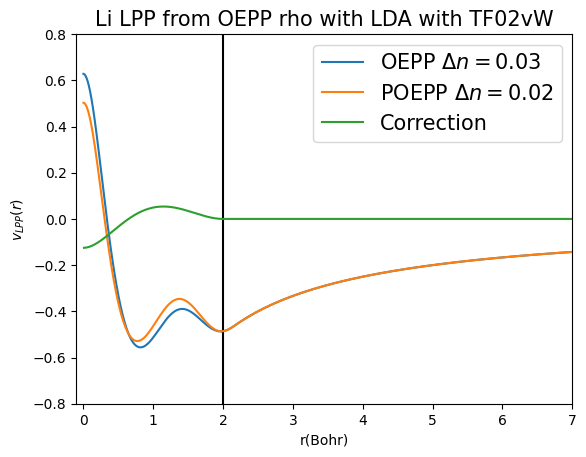

In [81]:
import matplotlib.pyplot as plt
plt.plot(r,vl, label='OEPP $\Delta n = 0.03$')
rcut = 2.0
r1=np.linspace(start=0.01,stop=10,num=1000)
# plt.plot(r,-3/(r+0.1))
#plt.scatter(np.arange(10),np.zeros(10)-4)
plt.vlines(x=rcut,ymin=-1,ymax=1,colors='k')
plt.plot(r,v, label='POEPP $\Delta n = 0.02$')
plt.plot(r1,delta_pp(r1,rcut,a), label='Correction')
plt.ylim(-0.8,0.8)
plt.xlim(-0.1,7)
plt.xlabel('r(Bohr)')
plt.ylabel('$v_{LPP}(r)$')
plt.legend(fontsize=15)
plt.title('Li LPP from OEPP rho with LDA with TF02vW',fontsize=15)

## Optimize rcut

In [47]:
def delta_pp(rcut, a):
    r = np.linspace(0, rcut, 100)
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v, r

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [50]:
key='Li'
grid = rho_ks.grid
# rcut = 2.0 # Taken from the GBRV PP cutoff radius
# r = np.linspace(0, rcut, 100)
a = np.load('a_tf02vw.npy')
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')

rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(rcut):
    rcut = float(np.atleast_1d(rcut)[0])  # <-- important

    print('Init')
    v, r = delta_pp(rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('rcut:', rcut, diff)
    return diff

In [53]:
res = minimize(delta_rho, x0=[2.0], method='Powell', bounds=[(1.5, 3)], options={'ftol': 1.0e-4})


Init
rcut: 2.0 0.020533545989926995
Init
rcut: 2.0729490168751576 0.023590386630952052
Init
rcut: 2.4270509831248424 0.283617806193654
Init
rcut: 1.8541019662496845 0.025681689788682176
Init
rcut: 1.9672055638361499 0.021574632477187303
Init
rcut: 1.982408578392591 0.020851851228336556
Init
rcut: 2.0071206592336623 0.020513055893893045
Init
rcut: 2.0028519311495363 0.020523395648040853
Init
rcut: 2.0071797882670546 0.02051467701489237
Init
rcut: 2.005161954907524 0.020518126988039138
Init
rcut: 2.006372500754989 0.02051453617754837
Init
rcut: 2.0067737489299406 0.02051403261086915
Init
rcut: 2.0069881512886885 0.02051275475447396
Init
rcut: 2.007021484725673 0.020514285420687624
Init
rcut: 2.006954817851704 0.020513313700655726
Init
rcut: 2.013976302577377 0.02054485208310571
Init
rcut: 2.0729490168751576 0.023590386630952052
Init
rcut: 2.4270509831248424 0.283617806193654
Init
rcut: 1.8541019662496845 0.025681689788682176
Init
rcut: 1.9672055638361499 0.021574632477187303
Init
rcut: 1

In [ ]:
0.02051331371166369

In [46]:
rcut = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

array([ 0.16393789, -0.04558777, -0.03146292])

In [ ]:
engine.write('POEPP_LDA_TF02vW.psp8')
np.save('rcut_tf02vw', rcut)